# Exercise 5: Profile Likelihood
 >__Created__:  16 Mar. 2023 for CLASHEP 23

### Introduction 
Consider the 2-parameter statistical model discussed in the lectures:

\begin{align}
    p(D | s, b) & = \textrm{Poisson}(N, s + b) \,\textrm{Poisson}(M, k b),
\end{align}

where $D = N, M$ are the observed data, $N$ is the count in the signal region and $M$ the count in either a background-dominated region or a Monte Carlo simulation of the background. The background estimate in the signal region is $B \pm \delta B = M / k \pm \sqrt{M} / k$. 

In exercise 3, we created a __confidence set__ for the parameters $s$ and $b$. In this exercise, we want to create a 1D confidence set for $s$, that is, we want to create a __confidence interval__ and make a statement of the form

\begin{align}
    s & \in [\underline{s}(D), \, \overline{s}(D)] \textrm{ at 68% CL}. 
\end{align}

### The Profile Likelihood
If we want to make a statistical statement about $s$ alone, we need a way to remove $b$ from the problem. The standard procedure is to *replace* all __nuisance parameters__ by their __conditional maximum likelihood estimates__, that is, by their MLE for given values of the parameters of interest (POI). Our parameter of interest in this problem is $s$ and the nuisance parameter is $b$. Replacing $b$ by

\begin{align}
    \hat{b} &= \frac{g + \sqrt{g^2+4(1+k) M s}}{2(1+k)}, \\
    g & = N + M - (1+k)  s,
\end{align}

in the likelihood function yields a function, 

\begin{align}
    L_p(s) & = p(D | s, \hat{b}(s)),
\end{align}

called the __profile likelihood__.

This function is useful because in the large data sample limit the statistic

\begin{align}
    t_s(D) & = -  2 \log \left[ \frac{L_p(s)}{L_p(\hat{s})} \right] ,
\end{align}

behaves like a $\chi^2$ variate with __1__ degree of freedom. This is another application of Wilks' theorem.

In [20]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

%matplotlib inline

In [21]:
# update fonts
FONTSIZE = 18
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

### CMS 2014 $H \rightarrow Z Z \rightarrow 4 \ell$ summary data


In [22]:
class Bag:
    pass
bag = Bag()

bag.N = 25
bag.M = 353
bag.k = 37.6
bag.MLE = True

bag.N1= bag.N
bag.M1= bag.M

### Define statistical model/likelihood and the statistic $t_s(D)$

For continuous distributions, such as a Gaussian, we refer to the __probability density function (pdf)__ from which a probability can be computed by integrating the pdf over an interval in the space of observations. For discrete distributions, we refer to their functional forms as __probability mass functions (pmf)__. 

In [23]:
def loglikelihood(D, s, tiny=1.e-20):
    N = D.N
    M = D.M
    k = D.k
    
    # compute conditional MLE of background, b_hat = f(s)
    g = N + M - (1+k) * s
    b_hat = (g + np.sqrt(g**2+4*(1+k)*M*s))/2/(1+k)
    
    ll  = st.poisson.logpmf(N, s+b_hat+tiny)
    ll += st.poisson.logpmf(M, k*b_hat+tiny)
    return ll

def s_hat(D):
    N = D.N
    M = D.M
    k = D.k
    # compute MLE of mean signal (the parameter of interest)
    s_est = N - M / k
    
    if not D.MLE:
        # replace negative signal estimates by zero
        s_est = s_est * (s_est > 0)
  
    return s_est

def logsuplikelihood(D):
    return loglikelihood(D, s_hat(D))

def statistic(D, s):
    return -2*(loglikelihood(D, s) - logsuplikelihood(D))

### Find 68% confidence interval

Solve

$$t_s(D) = 1$$

for $\underline{s}(D)$ and $\overline{s}(D)$.

In [24]:
def computeInterval(D):
    def F(s, args):
        return statistic(D, s) - 1
        
    s_est= s_hat(D)
    s_err= np.sqrt(D.N+1)
    
    # find s_L
    smin = max(0, s_est - 2*s_err)
    smax = s_est
    s_L  = op.brentq(F, smin, smax, args=(s_est))
       
    # find s_U
    smin = s_est
    smax = s_est * 2*s_err
    s_U  = op.brentq(F, smin, smax, args=(s_est))

    return (s_L, s_U)

In [25]:
interval = computeInterval(bag)
s_L, s_U = interval
print(f'interval: [{s_L:6.1f}, {s_U:6.1f}]')

interval: [  10.9,   21.0]


### Plot confidence interval

In [26]:
def plot_confidence_interval(t, D, interval,
                        xbins=80, xmin=0, xmax=40, 
                        ymin=0, ymax=1.2,
                        filename='profile_likelihood.png',
                        fgsize=(5, 5), ftsize=18):
                        
    # make 1 sub-plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)
    
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r'$s$', fontsize=ftsize)
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(r'$L_p(s)$', fontsize=ftsize)
    
    xstep = (xmax-xmin)/xbins
    x     = np.arange(xmin, xmax+xstep, xstep)
    y     = np.exp(-t(D, x)/2)

    ax.plot(x, y, linewidth=1, color='blue')
    
    # fill beneath the curve
    ax.fill_between(x, y, alpha=0.05, color='steelblue')

    # fill between [s_L, s_U]
    s_L, s_U = interval
    x = np.arange(s_L, s_U, 0.1)
    y = np.exp(-t(D, x)/2)   
    ax.fill_between(x, y, alpha=0.4, color='green', 
                    label=f'$s \in [{s_L:6.1f}, {s_U:6.1f}]$') 
    ax.legend()
    
    plt.tight_layout()

    plt.savefig(filename)
    
    plt.show()

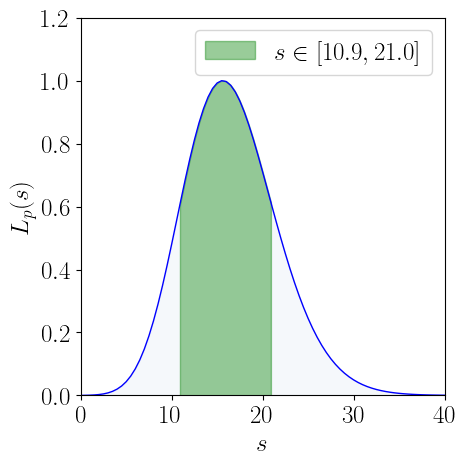

In [27]:
plot_confidence_interval(statistic, bag, interval)

## Check coverage
Choose a *fixed* parameter point $(s_0, b_0)$.
  1. simulate NEXP experiments
  1. compute statistic $t(D)$ for each experiment
  1. compute $cdf(t(D) = P(\chi^2 < t(D)|s_0, b_0)$
  1. count how often $cdf < CL$
  1. compute coverage

In [11]:
# 0. choose a "true" parameter point
N = bag.N1
M = bag.M1
k = bag.k
bag.s0 = N - M/k 
bag.b0 = M/k
NEXP   = 10000   # number of experiments to simulate

print(f'true s: {bag.s0:6.1f}')
print(f'true b: {bag.b0:6.1f}')

# 1. simulate experiments
N0 = st.poisson.rvs(bag.s0 + bag.b0, size=NEXP)
M0 = st.poisson.rvs(bag.k  * bag.b0, size=NEXP)

# 2. compute statistic for each experiment
bag.N = N0
bag.M = M0
t = statistic(bag, bag.s0)

# 3. compute cdf assuming t is a chi2 variate of 1 degree of freedom
ndf = 1
cdf = st.chi2.cdf(t, ndf)

# 4. count how often confidence set includes true means
CL  = 0.683
k   = cdf < CL

# 5. compute coverage
coverage = k.sum() / NEXP

print(f'coverage: {coverage:6.3f}')

true s:   15.6
true b:    9.4
coverage:  0.681


In [16]:
def plot_distribution(t, 
                      xbins=120, xmin=0, xmax=15, 
                      ymin=0, ymax=1.0,
                        filename='statistic_distribution_1D.png',
                        fgsize=(5, 5), ftsize=18):
                        
    # make 1 sub-plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)
    
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r'$t(D)$', fontsize=ftsize)
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(r'$p(t)$', fontsize=ftsize)
    
    # compute chi2 level for 2 degrees of freedom
    # for 1sigma
    xstep = (xmax-xmin)/xbins
    x     = np.arange(xmin, xmax+xstep, xstep)
    NDF   = 1
    y     = st.chi2.pdf(x, NDF)

    ax.hist(t, bins=xbins, 
            range=(xmin, xmax), 
            density=True, alpha=0.5, label='simulation')
    
    ax.plot(x, y, color='red', label=r'$p(\chi^2|ndf=1)$')
    ax.legend()
    ax.grid()

    plt.tight_layout()

    plt.savefig(filename)
    
    plt.show()

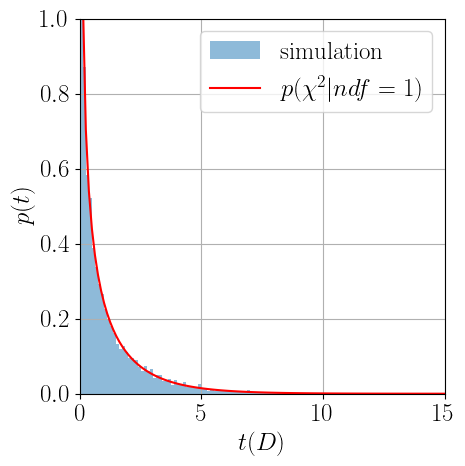

In [17]:
plot_distribution(t)